# Tutorial 7 - JPEG: Image compression algorithm

## Recap 
### What is JPEG?
JPEG stands for Joint Photographic Experts Group, which was a group of image processing experts that devised a standard for compressing images (ISO).
So, JPEG (or JPG) is not really a file format but rather an image compression standard. 
### The underlying assumptions of the JPEG algorithm
The JPEG algorithm is designed specifically for the human eye. It exploits the following biological properties of human sight:
- We are more sensitive to the illuminocity of color, rather than the chromatric value of an image, and
- We are not particularly sensitive to high-frequency content in images.

### In this tutorial:
- Read RGB image and perform padding
- Color conversion from RGB into YCbCr
- Chroma subsampling
- Blockwise DCT
- Quantization
- Zigzag scanning 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

### 1. Read RGB image
#### 1.1 OpenCV read image channels as BGR
Thus the first component img[:,:,0] is the blue channel and the last component img[:,:,2] is the red channel. 

In [2]:
img_BGR = cv2.imread('example_image.jpeg') ## this is in BGR
plt.imshow(img_BGR)

#### 1.2 Convert BRG image to RGB image

In [3]:
## Alternative 1: exchange the first and last color channels
img_RGB=np.zeros_like(img_BGR)
img_RGB[:,:,0]=img_BGR[:,:,2]
img_RGB[:,:,1]=img_BGR[:,:,1]
img_RGB[:,:,2]=img_BGR[:,:,0]
plt.imshow(img_RGB)

(333, 500, 3)

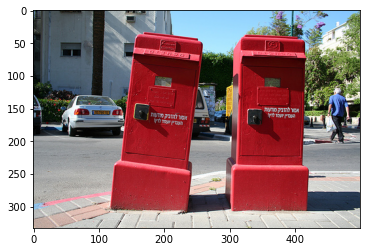

In [4]:
## Alternative 2: use cv2 library
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)
img_RGB.shape

#### 1.3 Image padding

(333, 500, 3)
(336, 512, 3)


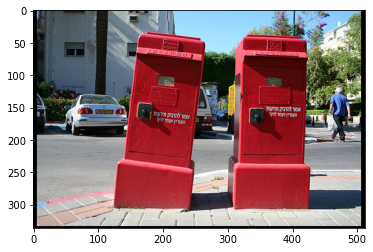

In [5]:
print(img_RGB.shape)
img_RGB = cv2.copyMakeBorder(img_RGB, top=0, bottom=3, left=6, right=6, borderType=cv2.BORDER_CONSTANT, value = 0)
print(img_RGB.shape)
plt.imshow(img_RGB)

### 2. Color Conversion from RGB to YCbCr

$$
\left[\begin{array}{c}
Y \\
C b \\
C r
\end{array}\right]=\left[\begin{array}{ccc}
65.481 & 128.553 & 24.966 \\
-37.797 & -74.203 & 112 \\
112 & -93.786 & -18.214
\end{array}\right]\left[\begin{array}{l}
R \\
G \\
B
\end{array}\right]+\left[\begin{array}{c}
16 \\
128 \\
128
\end{array}\right]
$$

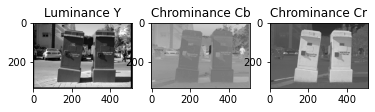

In [6]:
## alternative 1: use formula
def rgb2ycbcr(img_RGB):
    img_RGB = img_RGB/256.
    transform = np.array([[65.481, 128.553, 24.996], [-37.797, -74.203, 112], [112, -93.786, -18.214]])
    ycbcr = img_RGB.dot(transform.T) + np.array([16, 128, 128])
    return np.uint8(ycbcr)
img_YCbCr = rgb2ycbcr(img_RGB)
plt.subplot(2,3,1)
plt.imshow(img_YCbCr[:,:,0],cmap="gray")
plt.title('Luminance Y')
plt.subplot(2,3,2)
plt.imshow(img_YCbCr[:,:,1],cmap="gray")
plt.title('Chrominance Cb')
plt.subplot(2,3,3)
plt.imshow(img_YCbCr[:,:,2],cmap="gray")
plt.title('Chrominance Cr')
plt.show()

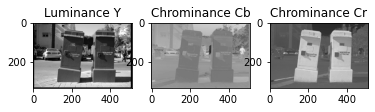

In [7]:
## alternative 2: use cv2 library
img_YCrCb=cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb) ## 
plt.subplot(2,3,1)
plt.imshow(img_YCrCb[:,:,0],cmap="gray")
plt.title('Luminance Y')
plt.subplot(2,3,2)
plt.imshow(img_YCrCb[:,:,2],cmap="gray")
plt.title('Chrominance Cb')
plt.subplot(2,3,3)
plt.imshow(img_YCrCb[:,:,1],cmap="gray")
plt.title('Chrominance Cr')
plt.show()

### 3. Chroma Subsampling (4:2:0)
4:2:0 will only sample colors out of half the pixels on the first row and ignores the second row of the sample completely.
<img src="fig/subsampling.png" width="300">

In [8]:
## a[x::y] means get every yth element starting at position x in array a
def chroma_subsample_420(YCbCr): 
    out = YCbCr.copy()
    
    ## Cb 
    # Vertically, every second element equals to element above itself.
    out[1::2, :, 1] = out[::2, :, 1]
    # Horizontally, every second element equals to the element on its left side.
    out[:, 1::2, 1] = out[:, ::2, 1]
    
    ## Cr
    # Vertically, every second element equals to element above itself.
    out[1::2, :, 2] = out[::2, :, 2]
    # Horizontally, every second element equals to the element on its left side.
    out[:, 1::2, 2] = out[:, ::2, 2]
    
    return out

A = np.random.randint(20, size = [8,8,3]) # 4:4:4
print('example array', A[:,:,2])
print('example array after 420 Chroma Subsampling', chroma_subsample_420(A)[:,:,2])

example array [[10  1  9 16 19  4 18  5]
 [12  9 14 18  6  1 16 15]
 [ 2  4  6  5 13  5 13  9]
 [ 8 12  0 12 11  0 17  6]
 [ 0 18 17 12 12  5  6  5]
 [13  2  6 15  7 18 14 10]
 [14 19  2 12  8 13  1  5]
 [14  4  7  7 18 18 16 14]]
example array after 420 Chroma Subsampling [[10 10  9  9 19 19 18 18]
 [10 10  9  9 19 19 18 18]
 [ 2  2  6  6 13 13 13 13]
 [ 2  2  6  6 13 13 13 13]
 [ 0  0 17 17 12 12  6  6]
 [ 0  0 17 17 12 12  6  6]
 [14 14  2  2  8  8  1  1]
 [14 14  2  2  8  8  1  1]]


In [9]:
subsampled_img_YCbCr = chroma_subsample_420(img_YCbCr)
plt.subplot(2,3,1)
plt.imshow(subsampled_img_YCbCr[:,:,0] ,cmap="gray")
plt.title('Luminance Y')
plt.subplot(2,3,2)
plt.imshow(subsampled_img_YCbCr[:,:,1] ,cmap="gray")
plt.title('Subsampled Cb')
plt.subplot(2,3,3)
plt.imshow(subsampled_img_YCbCr[:,:,2] ,cmap="gray")
plt.title('Subsampled Cr')
plt.show()

### 4. DCT

In [10]:
def C_func(x):
    if x == 0:
        return np.sqrt(2)/2
    else:
        return 1
    
def DCT_2D(f, M=8, N=8):
    F = np.zeros([M, N])
    for u in range(M):
        for v in range(N):
            temp = 0
            for i in range(M):
                for j in range(N):
                    temp += np.cos(((2*i+1)*u*np.pi)/(2*M)) * np.cos(((2*j+1)*v*np.pi)/(2*N)) * f[i, j]
            F[u, v] = temp * 2 * C_func(u) * C_func(v) / np.sqrt(M * N)
    
    return F

def IDCT_2D(F, M=8, N=8):
    f = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            temp = 0
            for u in range(M):
                for v in range(N):
                    temp += (2 * C_func(u) * C_func(v) / np.sqrt(M * N)) * np.cos(((2*i+1)*u*np.pi)/(2*M)) * np.cos(((2*j+1)*v*np.pi)/(2*N)) * F[u, v]
            f[i, j] = temp
    return f

In [11]:
## perform 8x8 DCT on each color channel:
dct_maps = []
for idx in range(subsampled_img_YCbCr.shape[2]):
    color_map = subsampled_img_YCbCr[:,:,idx]
    dct_map = np.zeros_like(color_map)
    # Do 8x8 DCT on image (in-place)
    for i in range(0, dct_map.shape[0], 8):
        for j in range(0, dct_map.shape[1], 8):
            dct_map[i:(i+8),j:(j+8)] = DCT_2D( color_map[i:(i+8),j:(j+8)] )
    dct_maps.append(dct_map)
plt.subplot(2,3,1)
plt.imshow(dct_maps[0],cmap="gray")
plt.title('DCT for Y')
plt.subplot(2,3,2)
plt.imshow(dct_maps[1],cmap="gray")
plt.title('DCT for sub_Cb')
plt.subplot(2,3,3)
plt.imshow(dct_maps[2],cmap="gray")
plt.title('DCT for sub_Cr')
plt.show()

### 5. Quantization

In [12]:
Q = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,48,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]])

In [13]:
for dct_map in dct_maps:
    for i in range(0, dct_map.shape[0], 8):
        for j in range(0, dct_map.shape[1], 8):
            dct_map[i:(i+8),j:(j+8)] = dct_map[i:(i+8),j:(j+8)] / Q
plt.subplot(2,3,1)
plt.imshow(dct_maps[0],cmap="gray")
plt.title('DCT for Y')
plt.subplot(2,3,2)
plt.imshow(dct_maps[1],cmap="gray")
plt.title('DCT for sub_Cb')
plt.subplot(2,3,3)
plt.imshow(dct_maps[2],cmap="gray")
plt.title('DCT for sub_Cr')
plt.show()

### 6. Zigzag scan
To group low frequency coefficients at the top, high frequency coefficients at the bottom of the vector.
<img src="fig/zigzag.png" width="200">


How to implement ZigZag:
- Observation: The pattern of path consist of mutiple diagonals.
- numpy.diagonal returns the diagonal of an array with the given offset. But it direction is "top left - bottom right".
- We can first inverse the array and then apply diagonal.
- Direction of diagonal changes each time.

In [14]:
def zigzag(in_arr):
#     print('in_arr', in_arr)
    ## by default, in_arr is of size [8,8]
    out_arr = []
    inverse_in_arr = in_arr[::-1,:]
#     print('inverse_in_arr', inverse_in_arr)
    for offset in range(1-a.shape[0], a.shape[0]):
#         print('diagonal offset', offset, 'diagonal direction', (2*(offset % 2)-1))
        curr_arr = np.diagonal(inverse_in_arr, offset)[::(2*(offset % 2)-1)]
#         print('curr_arr', curr_arr)
        out_arr.extend(curr_arr)
    out_arr = np.array(out_arr)
    return out_arr
a = np.array([
     [ 0,  1,  5,  6, 14, 15, 27, 28,],
     [ 2,  4,  7, 13, 16, 26, 29, 42,],
     [ 3,  8, 12, 17, 25, 30, 41, 43,],
     [ 9, 11, 18, 24, 31, 40, 44, 53,],
     [10, 19, 23, 32, 39, 45, 52, 54,],
     [20, 22, 33, 38, 46, 51, 55, 60,],
     [21, 34, 37, 47, 50, 56, 59, 61,],
     [35, 36, 48, 49, 57, 58, 62, 63,]])
zigzag(a)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [15]:
## perform zigzag on DCT maps
zigzag_maps = []
for dct_map in dct_maps:
    zigzag_map = [] ## [N, 64]
    for i in range(0, dct_map.shape[0], 8):
        for j in range(0, dct_map.shape[1], 8):
            zigzag_map.append(zigzag(dct_map[i:(i+8),j:(j+8)]))
    zigzag_map = np.array(zigzag_map)
    zigzag_maps.append(zigzag_map)


In [29]:
## visualize first 50 vectors
plt.subplot(2,3,1)
plt.imshow(zigzag_maps[0][:50, :],cmap="gray")
plt.title('ZigZag Scan for Y')
plt.subplot(2,3,2)
plt.imshow(zigzag_maps[1][:50, :],cmap="gray")
plt.title('ZigZag Scan for Cb')
plt.subplot(2,3,3)
plt.imshow(zigzag_maps[2][:50, :],cmap="gray")
plt.title('ZigZag Scan for Cr')
plt.show()

## Take Home Exercise
- Implement 4:2:2 Chroma Subsampling.
- Compare how different subsampling strategy can affect the quality of image.